# TDM MIMO FMCW Radar

<a href="https://rookiepeng.github.io/radarsimpy/" target="_blank" rel="nofollow"><img src="https://img.shields.io/badge/Documentation-latest-brightgree?style=flat&logo=read-the-docs" height="20" align="left"></a>

<br></br>
This is a time-division-multiplexing (TDM) multiple-input and multiple-output (MIMO) FMCW radar simulation example based on [`RadarSimPy`](https://github.com/rookiepeng/radarsimpy).

## Radar Model
### Transmitters

Setup the basic transmitter parameters through `Transmitter` module.

The following tables list the basic parameters of the 4-channel radar transmitter.

 | Parameter                       | Variable in `Transmitter`| Value                |
 |---------------------------------|--------------------------|----------------------|
 | Frequency ($f$)                 | `f`                      | [24.075, 24.175] GHz |
 | Time ($T$)                      | `t`                      | 80e-6 s              |
 | Transmitted power ($P_t$)       | `tx_power`               | 15 dBm               |
 | Pulse repetition period ($PRP$) | `prp`                    | 400 us               |
 | Number of pulses                | `pulses`                 | 1                  |

Here, `f` and `t` define the frequency modulation of the transmitter. The frequency changes from `24.075 GHz` to `24.175 GHz` within `80e-6 s`.

The transmitter array consists of 4 antenna elements with a $2\lambda$ spacing. Both of the transmitter antenna elements have the same radiation pattern $\cos{\theta}$. The gain of the transmitter antenna elements is 6 dB. For TDM configuration, `delay` parameter controls the time offset between transmitter channels.

- Tx Channel 1: 0 us delay
- Tx Channel 2: 100 us delay
- Tx Channel 3: 200 us delay
- Tx Channel 4: 300 us delay


In [1]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

wavelength = 3e8 / 24.125e9

angle = np.arange(-90, 91, 1)
pattern = 20 * np.log10(np.cos(angle / 180 * np.pi) + 0.01) + 6

tx_channel_1 = dict(location=(0, -12 * wavelength, 0),
                    azimuth_angle=angle,
                    azimuth_pattern=pattern,
                    elevation_angle=angle,
                    elevation_pattern=pattern,
                    delay=0)
tx_channel_2 = dict(location=(0, -8 * wavelength, 0),
                    azimuth_angle=angle,
                    azimuth_pattern=pattern,
                    elevation_angle=angle,
                    elevation_pattern=pattern,
                    delay=100e-6)
tx_channel_3 = dict(location=(0, -4 * wavelength, 0),
                    azimuth_angle=angle,
                    azimuth_pattern=pattern,
                    elevation_angle=angle,
                    elevation_pattern=pattern,
                    delay=200e-6)
tx_channel_4 = dict(location=(0, 0, 0),
                    azimuth_angle=angle,
                    azimuth_pattern=pattern,
                    elevation_angle=angle,
                    elevation_pattern=pattern,
                    delay=300e-6)

tx = Transmitter(f=[24.075e9, 24.175e9],
                 t=80e-6,
                 tx_power=15,
                 prp=400e-6,
                 pulses=1,
                 channels=[tx_channel_1, tx_channel_2, tx_channel_3, tx_channel_4])


### Receiver

Setup the receiver parameters through `Receiver` module.

The parameters of the receiver are listed in the table below.

| Parameter                        | Variable in `Receiver`| Value        |
|----------------------------------|-----------------------|--------------|
| Sampling rate ($f_s$)            | `fs`                  | 2 Msps       |
| Noise figure ($NF$)              | `noise_figure`        | 8 dB         |
| RF gain/loss ($G_{rf}$)          | `rf_gain`             | 20 dB        |
| Load resistor ($R_L$)            | `load_resistor`       | 500 $\Omega$ |
| Baseband voltage gain ($G_{BB}$) | `baseband_gain`       | 50 dB        |

The receiver array consists of 8 antenna elements with a $\lambda /2$ spacing. All of the receiver antenna elements have the same radiation pattern $\cos{\theta}$. The gain of the receiver antenna elements is 6 dB.

In [2]:
channels = []
for idx in range(0, 8):
    channels.append(
        dict(
            location=(0, wavelength / 2 * idx, 0),
            azimuth_angle=angle,
            azimuth_pattern=pattern,
            elevation_angle=angle,
            elevation_pattern=pattern,
        ))

rx = Receiver(fs=2e6,
              noise_figure=8,
              rf_gain=20,
              baseband_gain=50,
              load_resistor=500,
              channels=channels)


Create the FMCW radar model based on all the parameters defined above.

In [3]:
radar = Radar(transmitter=tx, receiver=rx)


Calculate the characteristics of the FMCW radar:

- Total channels: $$N_{Total}=N_{TX} \times N_{RX}$$

- Maximum range (*with I/Q baseband*): $$R_{max}=\frac{c f_s T}{2B}$$

- Maximum range (*without I/Q baseband*): $$R_{max}=\frac{c f_s T}{4B}$$

- Unambiguous velocity: $$v_{ua}=\frac{c}{2 CRP \times f_c}$$ or $$v_{ua}=\pm \frac{c}{4 CRP \times f_c}$$

- Range resolution: $$\delta_r=\frac{c}{2B}$$


### Targets
The propertities of targets are defined here. There are 3 targets in this simulation. The locations of the targets are defined through $(x, y, z)$ coordinates in meters, and the speeds of the targets are defined trough $(v_x, v_y, v_z)$ in $m/s$. The propertites of the targets also includes radar cross-section (RCS (dBsm)) and phase (degree).

In [4]:
target_1 = dict(location=(160, 0, 0), speed=(0, 0, 0), rcs=25, phase=0)
target_2 = dict(location=(80, -80, 0), speed=(0, 0, 0), rcs=20, phase=0)
target_3 = dict(location=(30, 20, 0), speed=(0, 0, 0), rcs=8, phase=0)

targets = [target_1, target_2, target_3]


## Simulate Baseband Signals

Use the `simulator` module to simulate the baseband samples. The user can choose between Python engine `simpy` or C++ engine `simc`.

The output baseband data is a 3-D matrix:

$[channels, pulses, ADC~samples]$

In [5]:
# Python engine
from radarsimpy.simulator import simpy
# C++ engine
from radarsimpy.simulator import simc

data = simc(radar, targets)
timestamp = data['timestamp']
baseband = data['baseband']


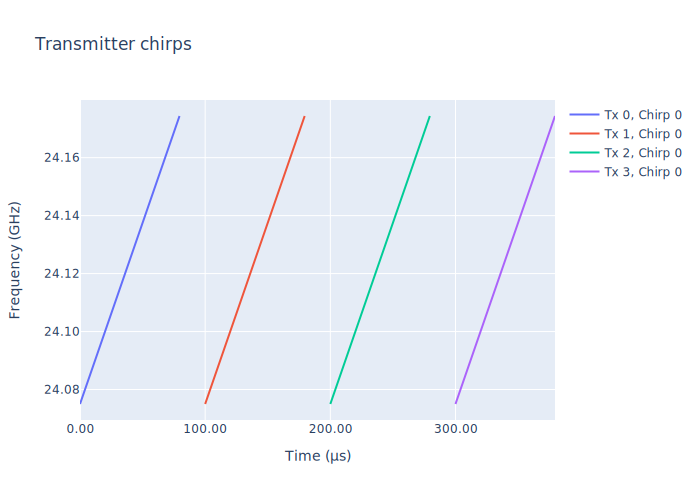

In [6]:
import plotly.graph_objs as go
from IPython.display import SVG, display

fig = go.Figure()

for idx in range(0, 1):
    for ch_idx in range(0, 32, 8):
        fig.add_trace(go.Scatter(
            x=timestamp[ch_idx, idx, :] * 1e6,
            y=np.linspace(
                radar.transmitter.fc_vect[0] - radar.transmitter.bandwidth / 2,
                radar.transmitter.fc_vect[0] + radar.transmitter.bandwidth / 2,
                radar.samples_per_pulse,
                endpoint=False,
            ) / 1e9,
            name='Tx ' + str(int(ch_idx / 8)) + ', Chirp ' + str(idx),
        ))


fig.update_layout(
    title='Transmitter chirps',
    yaxis=dict(tickformat='.2f', title='Frequency (GHz)'),
    xaxis=dict(tickformat='.2f', title='Time (µs)'),
)

# fig.show()
display(SVG(fig.to_image(format='svg', scale=1)))


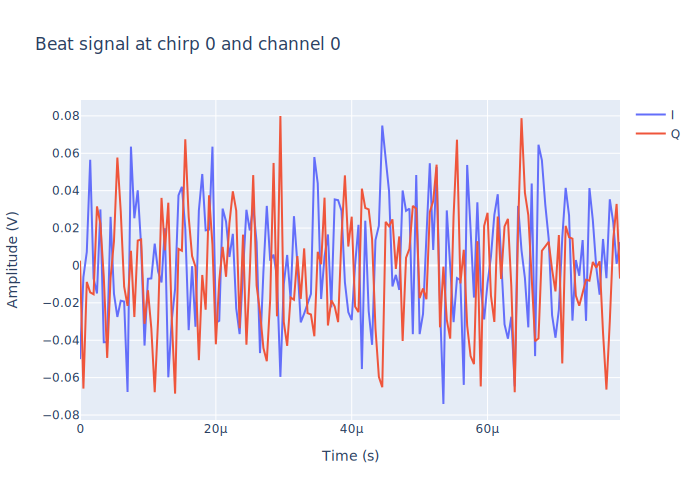

In [7]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=timestamp[0, 0, :],
    y=np.real(baseband[0, 0, :]),
    name='I',
))
fig.add_trace(go.Scatter(
    x=timestamp[0, 0, :],
    y=np.imag(baseband[0, 0, :]),
    name='Q',
))

fig.update_layout(
    title='Beat signal at chirp 0 and channel 0',
    yaxis=dict(title='Amplitude (V)'),
    xaxis=dict(title='Time (s)'),
)

# fig.show()
display(SVG(fig.to_image(format='svg', scale=1)))


## Radar Signal Processing
### Range profile

In [8]:
from scipy import signal
import radarsimpy.processing as proc

range_window = signal.chebwin(radar.samples_per_pulse, at=60)
range_profile = proc.cal_range_profile(radar, baseband, range_window)


Plot range profiles

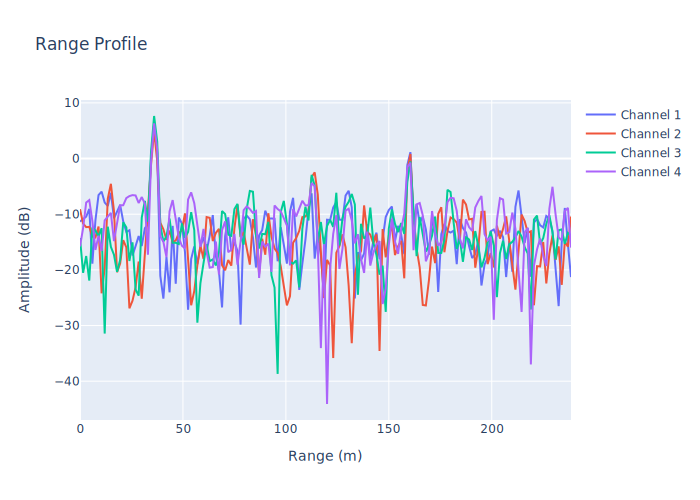

In [9]:
max_range = (3e8 * radar.receiver.fs *
             radar.transmitter.pulse_length /
             radar.transmitter.bandwidth / 2)
range_axis = np.linspace(
    0, max_range, radar.samples_per_pulse, endpoint=False)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=range_axis,
    y=20 * np.log10(np.abs(range_profile[0, 0, :])),
    name='Channel 1'
))
fig.add_trace(go.Scatter(
    x=range_axis,
    y=20 * np.log10(np.abs(range_profile[8, 0, :])),
    name='Channel 2'
))
fig.add_trace(go.Scatter(
    x=range_axis,
    y=20 * np.log10(np.abs(range_profile[16, 0, :])),
    name='Channel 3'
))
fig.add_trace(go.Scatter(
    x=range_axis,
    y=20 * np.log10(np.abs(range_profile[24, 0, :])),
    name='Channel 4'
))

fig.update_layout(
    title='Range Profile',
    xaxis=dict(title='Range (m)'),
    yaxis=dict(title='Amplitude (dB)'),
)

# fig.show()
display(SVG(fig.to_image(format='svg', scale=1)))


### Digital Beamforming

In [10]:
azimuth = np.arange(-90, 90, 1)

array_loc_x = np.zeros((1, len(radar.virtual_array)))
for va_idx, va in enumerate(radar.virtual_array):
    array_loc_x[0, va_idx] = va[1] * radar.transmitter.fc_vect[0] / 3e8

azimuth_grid, array_loc_grid = np.meshgrid(azimuth, array_loc_x)

A = np.transpose(
    np.exp(1j * 2 * np.pi * array_loc_grid *
           np.sin(azimuth_grid / 180 * np.pi)))

bf_window = np.transpose(
    np.array([signal.chebwin(len(radar.virtual_array), at=50)]))
AF = np.matmul(
    A, range_profile[:, 0, :] *
    np.repeat(bf_window, radar.samples_per_pulse, axis=1))

map_2d = proc.get_polar_image(np.transpose(AF), radar.samples_per_pulse, 180,
                              180)


Plot range-angle map

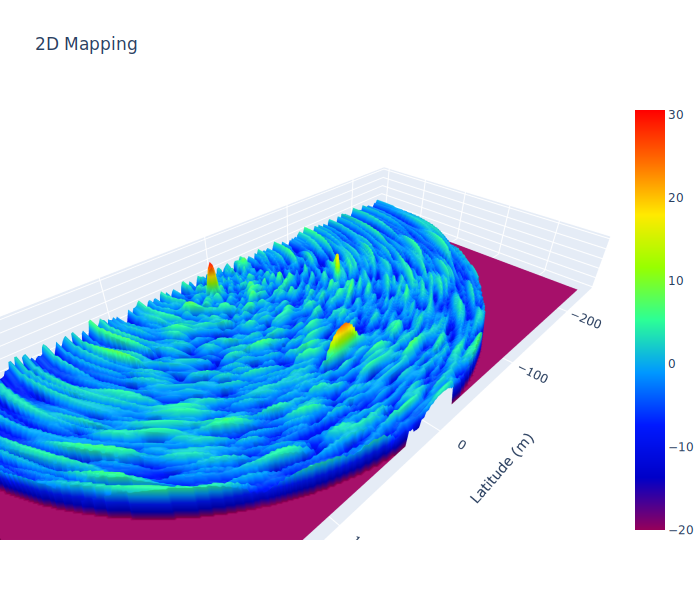

In [11]:
range_axis_la = np.linspace(0,
                            max_range,
                            radar.samples_per_pulse,
                            endpoint=False)
range_axis_lo = np.linspace(-max_range,
                            max_range,
                            radar.samples_per_pulse * 2,
                            endpoint=False)

fig = go.Figure()
fig.add_trace(go.Surface(x=range_axis_lo,
                         y=range_axis_la,
                         z=20 * np.log10(np.abs(map_2d) + 0.1),
                         colorscale='Rainbow'))

fig.update_layout(
    title='2D Mapping',
    height=600,
    scene=dict(
        xaxis=dict(title='Latitude (m)'),
        yaxis=dict(title='Longitude (m)'),
        zaxis=dict(title='Amplitude (dB)'),
        aspectmode='data',
    ),
    margin=dict(l=0, r=0, b=60, t=100),
)

# fig.show()
display(SVG(fig.to_image(format='svg', scale=1)))
